#  **Homework Problem**

This homework problem involves the autonomous segmentation of nuclei. This task was produced by Kaggle for the [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018) and instructed researchers to segment a wide range of nuclei across varied conditions. This Colab notebook contains all of the requisite code to complete the segmentation process so feel free to run all of the cells (Ctrl+F9) and visualize the predicted outputs.  Make sure Python3 and a GPU are enabled in "Edit -> Notebook Settings. This notebook is based on [this GitHub repository](https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018) and implemented the [U-Net architecture](https://arxiv.org/abs/1505.04597), which is a popular architecture for biomedical image segmentation.

#Your assignment is to:
#   #1 
Implement the [EarlyStopping](https://keras.io/callbacks/) callback so that the validation set [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) reaches at least 0.87 and cuts off before 50 epochs. Using validation set performance for early stopping helps reduce overfitting. You will need to modify the callback so that it will wait an appropriate amount of time before training stops. You will also need to modify the mode option. Use the training update log below as a reference to decide how long the model should wait before stopping. Because of random weight initialization, there is a chance that you may need to rerun the model to achieve the desired performance on the validation set. Feel free to use the Colab example Scott presented during class as a reference. 

# #2
Plot the training and validation set loss and Dice coefficient metrics for each epoch. The previous Colab example demonstrates how to access and plot this information using the history object, which was created by the [fit](https://keras.io/models/model/) function.


# #3
For the training set, identify the 5 samples with the highest Dice coefficient scores and the 5 samples with the lowest Dice coefficient scores. For those ten samples, display the input images, the ground truth masks, and the generated output masks. After displaying the images, briefly (in a couple sentences) comment on what you felt were the most notable characteristics of the 5 best and worst samples. There is no right or wrong answer to this question as these are based on your own observations. In a research setting, making observations such as this is vital to better understand the strengths and weaknesses of your model as well as the data you're analyzing.

You will need to use the predict function on the training set first to generate the output predictions and then calculate the Dice coefficients. Refer to the "calc_dice_coef" function defined in this script to calculate the Dice coefficients.  Run the "calc_dice_coef'" function for each predicted/ground truth pair individually (ie. iterate through the first column of the predicted and ground truth mask arrays). To save the Dice coefficients, it is advised that you first create an empty list and then write a for loop to append the output of the "calc_dice_coef"  function for each sample of the training set. [This link](https://www.programiz.com/python-programming/list) is a helpful resource if you need to review how to work with lists in Python. Once the list of Dice coefficients is created, you should input it into the "calc_best_and_worst_n_samples" function, which is also defined in this script. Use this function to create two nested lists (refer to the above link to learn about nested lists) that contain the index and Dice coefficients for the best and worst 5 samples.

Once you have the index and Dice coefficients for the best and worst 5 samples, you are ready to display the images. This script already contains an example of how to display the input images and generated masks for the test set. Feel free to copy this code for #3 and make the necessary modifications to display three columns of images instead of 2. You will be displaying 30 images in total with 10 input images in the first column, 10 ground truth masks in the second column, and 10 generated masks in the third column. Feel free to break up the plots into two figures of 15 images each if you would like to display the best and worst examples in seperately.  Include the Dice coefficient scores in the titles of each generated output image (ie. the title of each image in the third column). 

In [201]:
# ------ No need to change this code, just use it as is -------
import os
# Data download and unzipping
!wget –quiet  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget –quiet  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

if os.path.isdir('stage1_train'):
  !rm -rf 'stage1_train'
  
if os.path.isdir('stage1_test'):
  !rm -rf 'stage1_test'
  
!mkdir stage1_train stage1_test

!unzip -qq stage1_train.zip -d stage1_train/
!unzip -qq stage1_test.zip -d stage1_test/

--2018-12-02 05:00:50--  http://xn--quiet-xu3b/
Resolving xn--quiet-xu3b (xn--quiet-xu3b)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--quiet-xu3b’
--2018-12-02 05:00:50--  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2018-12-02 05:00:52--  http://xn--quiet-xu3b/
Resolving xn--quiet-xu3b (xn--quiet-xu3b)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--quiet-xu3b’
--2018-12-02 05:00:52--  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip
Resolving raw.git

In [0]:
# ------ No need to change this code, just use it as is -------
# Downloading and intstalling keras
!pip -q install keras

In [0]:
# ------ No need to change this code, just use it as is -------
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.
epochs = 50

In [0]:
# ------ No need to change this code, just use it as is -------
# Data Path
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [0]:
# ------ No need to change this code, just use it as is -------
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [0]:
# ------ No need to change this code, just use it as is -------
# Function read train images and mask return as nump array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n+1)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [0]:
# ------ No need to change this code, just use it as is -------
# Function to read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n+1)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test

In [0]:
# ------ No need to change this code, just use it as a function-------
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
# ------ No need to change this code, just use it as is -------
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [210]:
# ------ No need to change this code, just use it as is -------
# get train_data
train_img,train_mask = read_train_data()

# get test_data
test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
Train file loaded from memory

Getting and resizing test images ... 
Test file loaded from memory


In [0]:
# ------ No need to change this code, just use it as is -------
u_net = get_unet()

In [0]:
# ---- Implement Early stopping: Task #1 ------
import keras
stop_early = keras.callbacks.EarlyStopping(monitor='val_dice_coef',
                                           min_delta=0,
                                           patience=10,
                                           mode='max')
#set max number of epochs
epochs=50

In [213]:
# ------ You need to change -----------------
# fit model on train_data
print("\nTraining...")
history=u_net.fit(train_img,train_mask,
                  validation_split=0.15,
                  batch_size=16,
                  epochs=epochs,
                  callbacks=[stop_early])


Training...
Train on 569 samples, validate on 101 samples
Epoch 1/50
569/569 [==============================] - 20s 35ms/step - loss: 0.3005 - dice_coef: 0.4555 - val_loss: 0.1985 - val_dice_coef: 0.6014
Epoch 2/50
569/569 [==============================] - 13s 22ms/step - loss: 0.1449 - dice_coef: 0.7214 - val_loss: 0.1307 - val_dice_coef: 0.7574
Epoch 3/50
569/569 [==============================] - 13s 22ms/step - loss: 0.1144 - dice_coef: 0.7880 - val_loss: 0.1192 - val_dice_coef: 0.7676
Epoch 4/50
569/569 [==============================] - 13s 22ms/step - loss: 0.0975 - dice_coef: 0.8145 - val_loss: 0.1009 - val_dice_coef: 0.8083
Epoch 5/50
569/569 [==============================] - 13s 22ms/step - loss: 0.0975 - dice_coef: 0.8183 - val_loss: 0.1156 - val_dice_coef: 0.7889
Epoch 6/50
569/569 [==============================] - 13s 22ms/step - loss: 0.0888 - dice_coef: 0.8345 - val_loss: 0.0893 - val_dice_coef: 0.8254
Epoch 7/50
569/569 [==============================] - 13s 22ms/st

In [214]:
# ------ No need to change this code, just use it as is -------
print("Predicting")
# Predict on test data
test_mask = u_net.predict(test_img,verbose=1)

Predicting
65/65 [==============================] - 3s 39ms/step


In [215]:
# ------ No need to change this code, just use it as is -------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,200))
for i in range(40):
  cur_test_mask=test_mask[i,:,:,0]
  cur_image=test_img[i]
  plt.subplot(40,2,(i+1)*2-1)
  plt.imshow(cur_image)
  plt.title('Input Image')
  plt.subplot(40,2,(i+1)*2)
  plt.imshow(cur_test_mask,cmap='copper')
  plt.title('Generated Mask')


In [216]:
last_dice_coef=history.history['val_dice_coef'][len(history.history['val_dice_coef'])-1]
print('val_dice_coef: %0.2f' %last_dice_coef)

val_dice_coef: 0.85


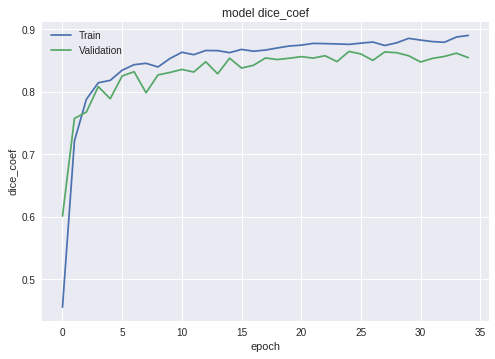

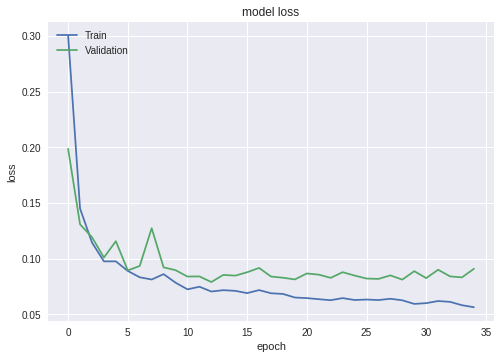

In [217]:
#Insert code to complete Task #2



def plot_train_and_val(history):
  plt.plot(history.history['dice_coef'])
  plt.plot(history.history['val_dice_coef'])
  plt.title('model dice_coef')
  plt.ylabel('dice_coef')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# call the function we just created to plot validation and test accuracy/loss 
plot_train_and_val(history)



In [0]:
# ------ No need to change this code, just use it as is -------
# computes DICE for a given ground truth mask and predicted mask 
def calc_dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
  
# this function finds the best and worst (#n_smaples) in terms of DICE score among all calculated DICE scores  
def calc_best_and_worst_n_samples(training_set_dice_coefs,n_samples):
  best_n_samples=[]
  worst_n_samples=[]
  for i in range(n_samples):
      best_n_samples.append([np.amax(training_set_dice_coefs),np.argmax(training_set_dice_coefs)])
      worst_n_samples.append([np.amin(training_set_dice_coefs),np.argmin(training_set_dice_coefs)])
      training_set_dice_coefs[np.argmax(training_set_dice_coefs)]=np.mean(training_set_dice_coefs)
      training_set_dice_coefs[np.argmin(training_set_dice_coefs)]=np.mean(training_set_dice_coefs)
  for i in range(n_samples):
      training_set_dice_coefs[best_n_samples[i][1]]=best_n_samples[i][0]
      training_set_dice_coefs[worst_n_samples[i][1]]=worst_n_samples[i][0]
  return best_n_samples,worst_n_samples

In [219]:
#Insert code to complete #3 below. Feel free to add more cells to split up the code.

#Generate output predictions on training set
pred_mask = u_net.predict(train_img,verbose=1)


670/670 [==============================] - 5s 7ms/step


In [0]:
#Create a list of the dice coefficients
train_dice_coef=[]
for i in range(0,train_mask.shape[0]):
  train_dice_coef.append(calc_dice_coef(train_mask[i],pred_mask[i]))

In [0]:
#Calculate the indicies of the 5 best and worst samples
[best_n_samples,worst_n_samples]=calc_best_and_worst_n_samples(train_dice_coef,5)

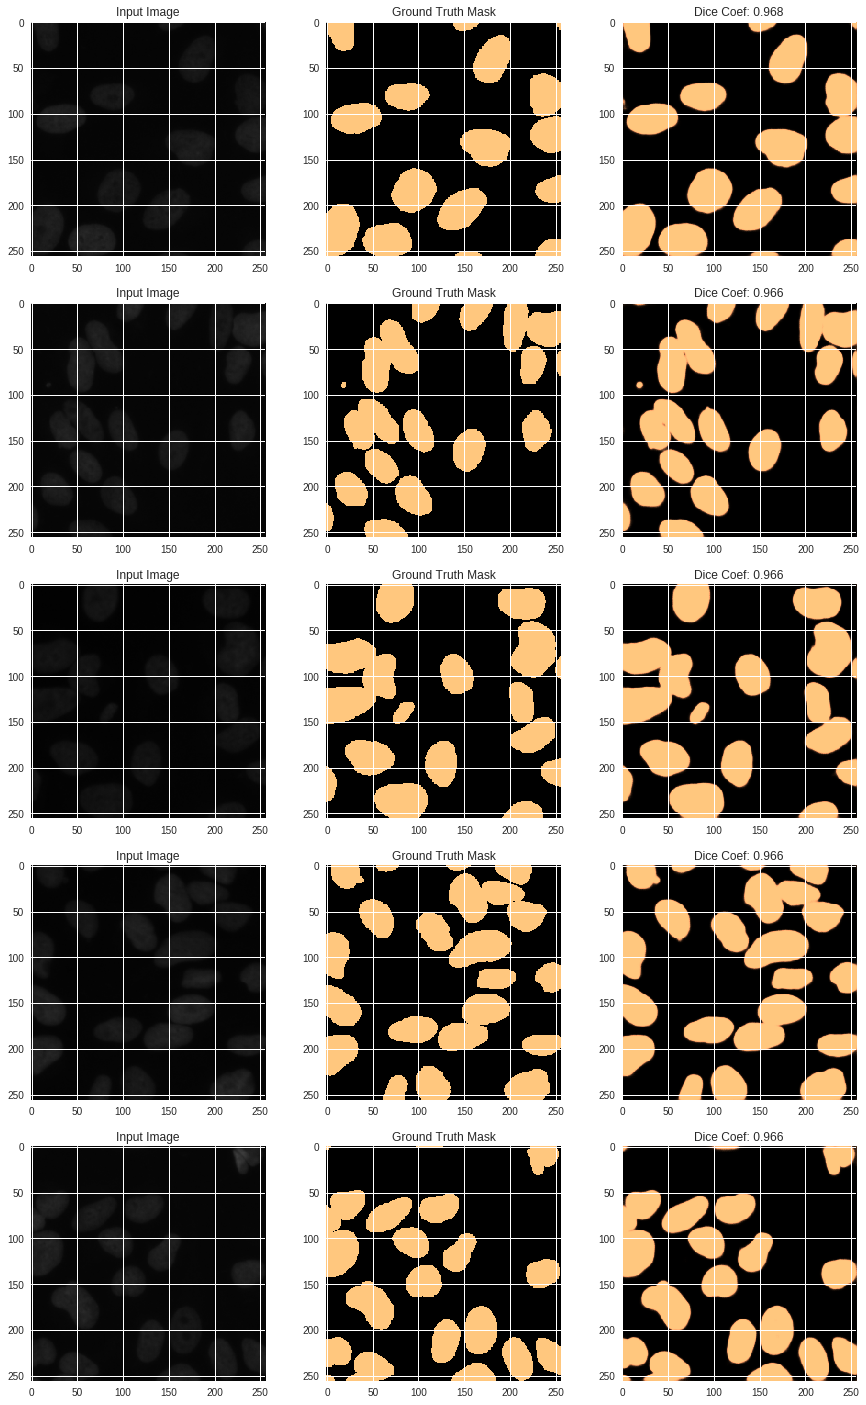

In [222]:
#Display best 5 images
rows=5
cols=3
plt.figure(figsize=(15,200/8))
for i in list(range(0,rows)):
  j=best_n_samples[i][1]
  cur_ground_mask=train_mask[j,:,:,0]
  cur_pred_mask=pred_mask[j,:,:,0]
  cur_image=train_img[j]
  plt.subplot(rows,cols,(i+1)*3-2)
  plt.imshow(cur_image)
  plt.title('Input Image')
  plt.subplot(rows,cols,(i+1)*3-1)
  plt.imshow(cur_ground_mask,cmap='copper')
  plt.title('Ground Truth Mask')
  plt.subplot(rows,cols,(i+1)*3)
  plt.imshow(cur_pred_mask,cmap='copper')
  plt.title("Dice Coef: %.3f" %best_n_samples[i][0])

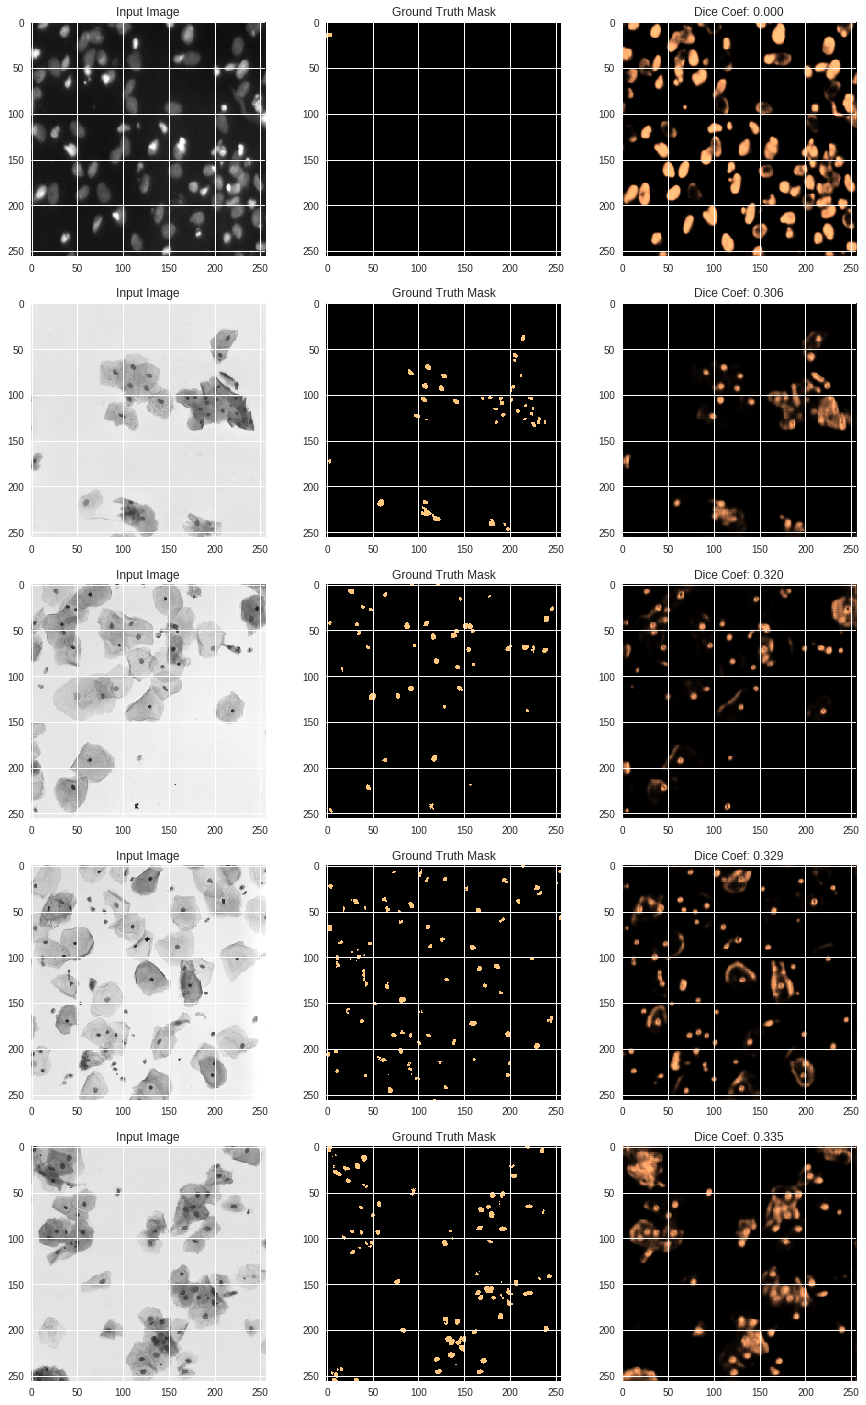

In [223]:
#Display worst 5 images
rows=5
cols=3
plt.figure(figsize=(15,200/8))
for i in list(range(0,rows)):
  j=worst_n_samples[i][1]
  cur_ground_mask=train_mask[j,:,:,0]
  cur_pred_mask=pred_mask[j,:,:,0]
  cur_image=train_img[j]
  plt.subplot(rows,cols,(i+1)*3-2)
  plt.imshow(cur_image)
  plt.title('Input Image')
  plt.subplot(rows,cols,(i+1)*3-1)
  plt.imshow(cur_ground_mask,cmap='copper')
  plt.title('Ground Truth Mask')
  plt.subplot(rows,cols,(i+1)*3)
  plt.imshow(cur_pred_mask,cmap='copper')
  plt.title("Dice Coef: %.3f" %worst_n_samples[i][0])

#Insert your brief analysis for #3 below.

In the 5 best samples the ground truth masks contained larger blobs while in the 5 worst samples the ground truth masks contained small blobs. In the 5 best samples the predicted masks had completely solid regions with edges only slightly softer than the ground truth. In the 5 worst samples the predicted masks were not completely solid with some containing dark spaces in the center of the blob. The 5 best samples were all images in which the nuclei were light and the surrounding was dark. In 4 out of the 5 worst samples the contrast was inverted.